In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive

#Mount Google Drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [3]:
# Define the path to the excel file (replace with your file path on Google Drive)
file_path = '/content/MyDrive/MyDrive/df14.csv'

In [4]:
# Read the .csv file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
# Display the first few rows of the DataFrame
print(df.head())

              Datetime        NO2       PM10     PM2.5     RH       Temp  \
0  2018-01-01 00:00:00  64.216400  14.020000  6.980000  65.84  20.880000   
1  2018-01-01 01:00:00  46.040667  15.966667  8.900000  65.84  21.116667   
2  2018-01-01 02:00:00  28.285000  12.050000  5.183333  65.84  20.716667   
3  2018-01-01 03:00:00  24.381333  12.750000  5.133333  65.84  20.383333   
4  2018-01-01 04:00:00  21.431167  10.700000  4.250000  65.84  20.466667   

           WD        WS  
0   80.880000  0.300000  
1  152.250000  0.233333  
2  163.016667  0.266667  
3   55.550000  0.233333  
4   33.583333  0.250000  


In [7]:
# Calculate the percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Print the missing percentage per column
print("Percentage of missing values per column:")
print(missing_percentage)

Percentage of missing values per column:
Datetime    0.0
NO2         0.0
PM10        0.0
PM2.5       0.0
RH          0.0
Temp        0.0
WD          0.0
WS          0.0
dtype: float64


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load dataset (ensure 'Datetime' is parsed correctly)
df = pd.read_csv(file_path, parse_dates=["Datetime"], index_col="Datetime")

# Select features (excluding PM10 itself to prevent data leakage)
features = ["NO2", "PM2.5", "RH", "Temp", "WD", "WS"]

# Create lag features for NO2
for lag in range(1, 25):  # Using past 24 hours of NO2 data
    df[f"PM10_lag{lag}"] = df["PM10"].shift(lag)

# Drop NaN values after lag creation
df = df.dropna()

# Define X (independent variables) and y (target variable)
X = df[features + [f"PM10_lag{lag}" for lag in range(1, 25)]]
y = df["PM10"]

# Standardize features (not target variable)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
#train test split
train_size = int(0.8 * len(df))  # 80% training, 20% testing
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [10]:
#Train the Random Forest Model
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [11]:
#Evaluate model performance
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove squared parameter
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

MAE: 1.736
RMSE: 3.800
R² Score: 0.815


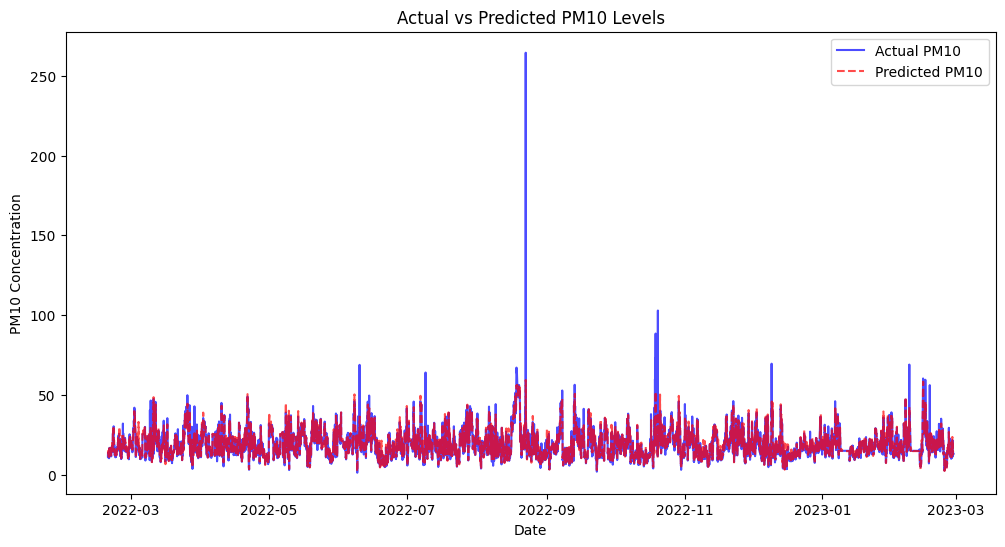

In [12]:
#visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual PM10", color="blue", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted PM10", color="red", linestyle="dashed", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("PM10 Concentration")
plt.title("Actual vs Predicted PM10 Levels")
plt.legend()
plt.show()

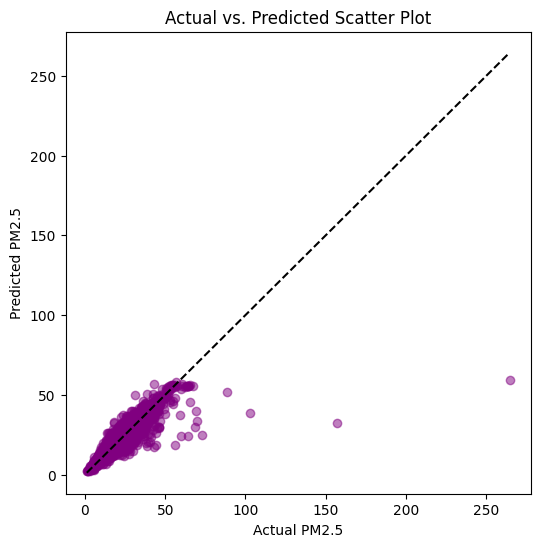

In [13]:
#Scatter Plot for Correlation
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="purple")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="black")  # 45-degree line
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs. Predicted Scatter Plot")
plt.show()

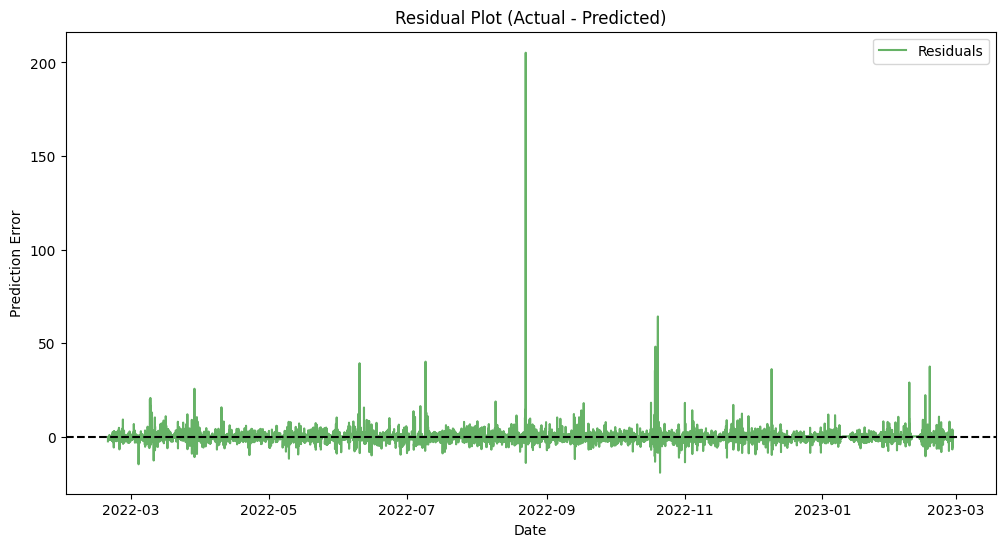

In [14]:
#Residual Plot (Errors Over Time)
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, label="Residuals", color="green", alpha=0.6)
plt.axhline(0, linestyle="dashed", color="black")
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.title("Residual Plot (Actual - Predicted)")
plt.legend()
plt.show()

In [15]:

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [16]:
# Define parameter grid for RandomizedSearchCV
random_grid = {
    "n_estimators": [50, 100, 200, 500],  # Number of trees
    "max_depth": [10, 20, 30, None],  # Depth of each tree
    "min_samples_split": [2, 5, 10],  # Minimum samples per split
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
    "max_features": ["auto", "sqrt"],  # Features considered per split
    "bootstrap": [True, False]  # Use bootstrap sampling
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV (faster search)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=random_grid,
    n_iter=20,  # Number of random configurations
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)



In [17]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Best model
best_rf_random = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
27 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", li

Best Parameters from RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [18]:
# Define parameter grid for GridSearchCV (based on best results from RandomizedSearchCV)
param_grid = {
    "n_estimators": [100, 200, 300],  # Fine-tuning number of trees
    "max_depth": [20, 30],  # Depth of trees
    "min_samples_split": [2, 5],  # Min samples per split
    "min_samples_leaf": [1, 2],  # Min samples per leaf
    "max_features": ["auto", "sqrt"],  # Features considered per split
    "bootstrap": [True]  # Fix bootstrap if determined earlier
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# Best model
best_rf_grid = grid_search.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", l

Best Parameters from GridSearchCV: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [20]:
# Make predictions with the best Random Forest model
y_pred = best_rf_grid.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove 'squared' parameter
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually using NumPy
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Optimized Random Forest - MAE: {mae:.3f}")
print(f"Optimized Random Forest - RMSE: {rmse:.3f}")
print(f"Optimized Random Forest - R² Score: {r2:.3f}")

Optimized Random Forest - MAE: 1.834
Optimized Random Forest - RMSE: 3.916
Optimized Random Forest - R² Score: 0.804


In [22]:
# XGBoost Implementation XGBoost (Extreme Gradient Boosting) is an advanced implementation of Gradient Boosting
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Assuming your data is prepared as `X_train`, `y_train`, `X_test`, and `y_test`

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove 'squared' parameter, calculate manually below
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually using NumPy
r2 = r2_score(y_test, y_pred)

print(f"XGBoost - MAE: {mae}")
print(f"XGBoost - RMSE: {rmse}")
print(f"XGBoost - R² Score: {r2}")

# Save the model
joblib.dump(xgb_model, "xgboost_model.pkl")


XGBoost - MAE: 1.8285252039412954
XGBoost - RMSE: 4.338038833701502
XGBoost - R² Score: 0.7594611142485419


['xgboost_model.pkl']

In [24]:
# LSTM (Long Short-Term Memory)
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model



# Feature Scaling (Normalizing)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['PM10']])

# Prepare the data for LSTM (look-back window)
def create_dataset(data, look_back=24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 24
X, y = create_dataset(df_scaled, look_back)

# Reshape X to be 3D for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform([y_test])

# Evaluate the model
mae = mean_absolute_error(y_test_rescaled[0], y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled[0], y_pred_rescaled))
r2 = r2_score(y_test_rescaled[0], y_pred_rescaled)

print(f"LSTM - MAE: {mae}")
print(f"LSTM - RMSE: {rmse}")
print(f"LSTM - R² Score: {r2}")

# Save the model
model.save("lstm_model.h5")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 3.9750e-04
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 2.0106e-04
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 1.7570e-04
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1.9745e-04
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1.8438e-04
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 1.6900e-04
Epoch 7/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 1.8057e-04
Epoch 8/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 1.8208e-04
Epoch 9/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 2.0154e-04
Epoch 10/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 1.8433e-04
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


LSTM - MAE: 2.450558804846403
LSTM - RMSE: 4.837852901993779
LSTM - R² Score: 0.7009133180572789


In [25]:
pip install lightgbm


In [29]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import joblib



# Feature Scaling (Normalizing)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['PM10']])

# Prepare data for LightGBM (with lags)
def create_dataset(data, look_back=24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 24  # 24 hours look-back for prediction
X, y = create_dataset(df_scaled, look_back)

# Split into train-test set (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=10)] # Using the callback
)

# Make predictions
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Inverse transform to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
# rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)  # This line caused the error
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))  # Calculate RMSE manually using NumPy
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"LightGBM - MAE: {mae}")
print(f"LightGBM - RMSE: {rmse}")
print(f"LightGBM - R² Score: {r2}")

# Save the model
joblib.dump(lgb_model, "lightgbm_model.pkl")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 35906, number of used features: 24
[LightGBM] [Info] Start training from score 0.051612
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0149272
LightGBM - MAE: 2.4714070791636424
LightGBM - RMSE: 4.655983021322371
LightGBM - R² Score: 0.7229778266678173


['lightgbm_model.pkl']

In [31]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid for LightGBM
param_grid = {
    'num_leaves': [31, 40, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# Create LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print(f"Best parameters: {grid_search.best_params_}")

# Make predictions using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Fine-Tuned LightGBM - MAE: {mae}")
print(f"Fine-Tuned LightGBM - RMSE: {rmse}")
print(f"Fine-Tuned LightGBM - R² Score: {r2}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 35906, number of used features: 24
[LightGBM] [Info] Start training from score 0.051612
Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 31}
Fine-Tuned LightGBM - MAE: 0.008008088194026946
Fine-Tuned LightGBM - RMSE: 0.015040108481655151
Fine-Tuned LightGBM - R² Score: 0.7187730528625724


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'num_leaves': np.arange(20, 100, 10),
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': np.arange(100, 500, 50)
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

# Best hyperparameters found
print(f"Best parameters: {random_search.best_params_}")

# Make predictions using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually using NumPy
r2 = r2_score(y_test, y_pred)

print(f"Fine-Tuned LightGBM - MAE: {mae}")
print(f"Fine-Tuned LightGBM - RMSE: {rmse}")
print(f"Fine-Tuned LightGBM - R² Score: {r2}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 35906, number of used features: 24
[LightGBM] [Info] Start training from score 0.051612
Best parameters: {'num_leaves': 20, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01}
Fine-Tuned LightGBM - MAE: 0.008024607260992397
Fine-Tuned LightGBM - RMSE: 0.01509377075679642
Fine-Tuned LightGBM - R² Score: 0.7167626683955837


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
